# reads span loop regions

In [94]:
import pandas as pd
import numpy as np
import datatable as dt
import gc
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
mpl.rcParams['pdf.fonttype'] = 42
sns.set_color_codes("muted")

In [95]:
# Loading
def LoadMatrixReader(filename, Chunksize, usecols, sepstr="\t"):
    file_reader = pd.read_table(filename, sep=sepstr,
                                chunksize=Chunksize, iterator=True,
                                header=0, index_col=None, usecols = usecols)
    return (file_reader)

# Read talbles No header
def LoadTables(filename, sepstr):
    dt_df = dt.fread(filename, sep=sepstr, header=True)
    df  = dt_df.to_pandas()
    del dt_df
    return(df)

# Binsize
def Binsize(binsize, p_array):
    p_array = np.divide(p_array, binsize).astype("int")*binsize
    return(p_array)

# Remove the fragments with the same bins
def Deduplicate(df, binsize):
    df.loc[:, "posbin"] = Binsize(binsize, (df["start"].values + df["end"].values)/2 )
    Dedup_df = df.groupby(["read_name","posbin"], as_index=False).first()
    Dedup_df = Dedup_df.reset_index()
    return(Dedup_df)

# Find Loop anchors
def FindAnchors(df, bin_DF):
    df.loc[:, "matchID"] = df.loc[:, "chrom"].str.cat( df.posbin.astype("str"), sep="_")
    matchP = df.matchID.isin( bin_DF.index.to_list()  ) 
    df.loc[:, "anchorID"] = "NaN"
    df.loc[matchP, "anchorID"] = bin_DF.loc[ df.loc[matchP, "matchID"].to_list() ].values
    return(df)

# Filter reads not in chr1:chrX
def Filterdf(df):
    chrlist = ["chr%d"%i for i in range(1,22+1)]
    chrlist.append("chrX")
    df = df.loc[df.chrom.isin(chrlist), :]
    return(df)

# Read Match Loops
def ReadMatchLoops(df, binsize, spannum=1):
    read_dict = {
        "chrom":[],
        "read_name":[],         
        "Fragnum":[],
        "Findloops":[],
        "LoopIDs":[] }
    for (chrom, read_name), readDF in df.groupby(["chrom","read_name"]):
        Fragnum = len(readDF)
        if Fragnum < 2: # 1 fragment reads not calculate
            continue
        gregionDF = regionDF_dict[chrom]
        Findloops, LoopIDs = 0, ""
        #matchIDs = readDF.matchID.to_list()
        posmatchIDs = readDF.posbin.to_list()
        # matchIDs in left and right anchords
        #matchP = ( gregionDF.pos1binID.isin(matchIDs) ) & ( gregionDF.pos2binID.isin(matchIDs) )
        # flank bins
        lr_posmatchIDs = posmatchIDs
        for span_i in range(1, spannum+1):
            lr_posmatchIDs.extend( [ ID + int(binsize*spannum) for ID in posmatchIDs ]  )
            lr_posmatchIDs.extend( [ ID - int(binsize*spannum) for ID in posmatchIDs ] )
        matchP = ( gregionDF.pos1bin.isin(lr_posmatchIDs) ) & ( gregionDF.pos2bin.isin(lr_posmatchIDs) )
        Findloops = sum(matchP)
        if Findloops >= 1:
            LoopIDs = ",".join( gregionDF.loc[matchP,"LoopID"].astype("str").to_list() )
        # save result
        read_dict["chrom"].append( chrom )
        read_dict["read_name"].append( read_name)
        read_dict["Fragnum"].append( Fragnum )
        read_dict["Findloops"].append(Findloops)
        read_dict["LoopIDs"].append(LoopIDs)         
    gc.collect()
    ## dataframe
    read_summary_df = pd.DataFrame(read_dict)
    return(read_summary_df)
            
## Read domain distribution summary
def CountSummary(read_summary_df):
    read_summary_df.loc[:, "type"] = read_summary_df["Findloops"].astype("str").values
    read_summary_df.loc[read_summary_df.Findloops >= 4, "type"] = ">=4" 
    return(read_summary_df)


In [96]:
# Loading
filename = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_test.csv"
regionfile = "/data1/ZJY/Pore-C/Analysis/HiC_NA12878/Rao2014_Loops/GSE63525_GM12878_hg38_looplist.txt"

# Binsize
binsize = 10000
### Merge_Align_Fragment_RvdF.csv
Chunksize = 500000
usecols = ["read_name", "start", "end", "chrom"]
df_reader = LoadMatrixReader(filename, Chunksize,  usecols, ",")

# Loop Anchors  region preprocess
filtersize = binsize*2
regionDF = LoadTables(regionfile,"\t")
regionDF.columns = ["chrom1", "start1", "end1","chrom2", "start2", "end2", "color"]
regionDF = regionDF.sort_values(by=["chrom1", "start1", "end1","chrom2", "start2", "end2"]).reset_index(drop=True)
regionDF.loc[:, "pos1bin"] =  Binsize(binsize,  (regionDF.start1.values + regionDF.end1.values)/2 )
regionDF.loc[:, "pos2bin"] =  Binsize(binsize,  (regionDF.start2.values + regionDF.end2.values)/2 )
regionDF.loc[:, "pos1binID"] = regionDF.loc[:, "chrom1"].str.cat( regionDF["pos1bin"].astype("str"), sep="_" )
regionDF.loc[:, "pos2binID"] =  regionDF.loc[:, "chrom2"].str.cat( regionDF["pos2bin"].astype("str"), sep="_" )

print("Loading %d loops"%len(regionDF) )
## intra chromosome loops
regionDF = regionDF.loc[regionDF.chrom1 ==regionDF.chrom2, :]
## filter out loopsize < 2*binsize
## loop size 100,000
loopsize_thred = 100000
regionDF = regionDF.loc[(regionDF.pos2bin - regionDF.pos1bin) >= loopsize_thred , :]
## filter out loops with the same pos1bin-pos2bin pair
regionDF = regionDF.drop_duplicates(subset=["chrom1", "chrom2", "pos1bin", "pos2bin"], keep="first", ignore_index=True)
regionDF.loc[:,"LoopID"] = regionDF.index.values + 1
print("After filter, %d loops"%len(regionDF) )
regionDF_dict = dict( list(regionDF.groupby("chrom1"))  )
## region bin DF
l = regionDF.loc[:,["chrom1", "pos1bin", "LoopID"]]
l.loc[:, "anchorID"] = l.loc[:, "LoopID"].astype("str") + "_l"
l.columns = ["chrom", "posbin", "LoopID","anchorID"]
r= regionDF.loc[:,["chrom2", "pos2bin", "LoopID"]]
r.loc[:, "anchorID"] = r.loc[:, "LoopID"].astype("str") + "_r"
r.columns = ["chrom", "posbin", "LoopID","anchorID"]
bin_DF = pd.concat([l, r])
## region df l, r ID
regionDF.loc[:,"anchorID_l"] = l.anchorID.values
regionDF.loc[:,"anchorID_r"] = r.anchorID.values
del(r, l)
bin_DF.loc[:, "matchID"] =  bin_DF.loc[:, "chrom"].str.cat( bin_DF["posbin"].astype("str"), sep="_" )
bin_groupDF = bin_DF.groupby("matchID")["anchorID"].apply( lambda x : x.str.cat(sep=";") )
#bin_DF = bin_DF.set_index("matchID")
#bin_groupDF

Loading 9447 loops
After filter, 8014 loops


In [97]:
Holdlist = []
for df in df_reader:
    print("Loading %d"%len(df) )
    df = Filterdf(df)
    df = Deduplicate(df, binsize)
    df = FindAnchors(df, bin_groupDF)
    read_summary_df = ReadMatchLoops(df, binsize, 2)
    read_summary_df = CountSummary(read_summary_df)
    Holdlist.append(read_summary_df)
    #del(df, df_filter, read_summary_df)
    gc.collect()
Read_df = pd.concat(Holdlist)
#del(Holdlist)
gc.collect()
#Read_df

Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 500000
Loading 499999


0

In [99]:
read_summary_df

,chrom,read_name,Fragnum,Findloops,LoopIDs,type
0,chr1,00068259-1b8e-4eef-bde0-cbc3c30dff5c,4,0,,0
1,chr1,000d2ab1-87ef-4d53-9e97-8bd4bfa835ec,3,0,,0
2,chr1,0017ce97-e799-42ae-a95b-eb329e69727d,7,0,,0
3,chr1,00547e16-fd3b-4a4d-94c5-3c0dc0342431,2,0,,0
4,chr1,0054fd03-0e78-4efc-bd0c-72ceb18de312,4,0,,0
...,...,...,...,...,...,...
86281,chrX,ff1b93c0-386d-4af7-a210-c899ce832899,5,0,,0
86282,chrX,ff27a895-1cbc-4f98-a351-05cf18e0527b,2,0,,0
86283,chrX,ff58068d-1520-4b60-acaa-414e7ad6436e,3,0,,0
86284,chrX,ff922e86-58ee-475b-a5c9-b2cd78bd6bff,10,1,7915,1


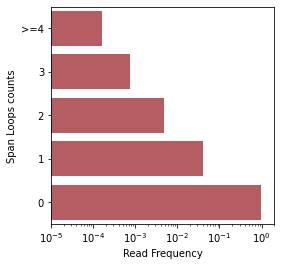

In [110]:
## Loop counts log scale
allcount_ratio = Read_df["type"].value_counts(normalize = True)
allcount_ratio = pd.DataFrame(allcount_ratio).reset_index()
allcount_ratio.columns = ["Findloops", "Read Frequency"]
allcount_ratio.to_csv("Findloops_bar_plot.csv", sep="\t", header=True)

f, ax = plt.subplots(figsize=(4, 4))
sns.set_color_codes("deep")
sns.barplot(x = "Read Frequency",
            y = "Findloops",         
            data = allcount_ratio,
            color="r" )
ax.invert_yaxis() # 倒置y轴
plt.xscale('log')
plt.xlabel("Read Frequency")
plt.ylabel("Span Loops counts")
plt.xlim([10**-5, 2])
plt.savefig("Span_Loops_count_bar_plot1.pdf")

In [101]:
allcount_ratio

,Findloops,Read Frequency
0,0,0.953909
1,1,0.040235
2,2,0.004928
3,3,0.000767
4,>=4,0.000161


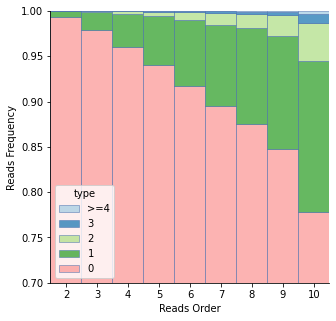

In [119]:
# Fragment vs span loop
## only calculate loop reads
Read_df.loc[Read_df.Fragnum>=10, "Fragnum"] = 10
Read_df_filter = Read_df
#Read_df_filter = Read_df.loc[Read_df.Findloops > 0, :]
f, ax = plt.subplots(figsize=(5, 5))
sns.despine(f)
sns.histplot(
    Read_df_filter,
    x="Fragnum", hue="type",
    hue_order = [">=4","3","2","1", "0"],
    binwidth = 0.5,
    discrete=True,
    multiple="fill",
    palette="Paired",
    edgecolor="b",
    linewidth=.5)
plt.xlabel("Reads Order")
plt.ylabel("Reads Frequency")
#plt.show()
plt.ylim([0.7,1])
plt.savefig("Fragnums_vs_Span_Loop_PairAnchors1.1.pdf")

In [120]:
Read_df.loc[Read_df.Findloops>=1, :]

,chrom,read_name,Fragnum,Findloops,LoopIDs,type
27,chr1,00e543e6-8f7d-40a5-b3c9-550c7381c14d,5,1,600,1
33,chr1,012ad2c5-45ec-4636-8eac-99e60b502add,5,1,287,1
46,chr1,0177999c-2961-4a07-b701-aec677d3111b,4,1,377,1
78,chr1,024af5ae-0793-41fa-9ac4-9c90ce42d6a1,6,1,465,1
108,chr1,0330f414-c712-4999-b560-6ed019b34111,4,1,266,1
...,...,...,...,...,...,...
86119,chrX,ecf04d3c-88ee-4ca1-b8c5-d3e3308a7033,6,1,7914,1
86141,chrX,eebea142-5a93-4e1b-82ba-4ba8a9b6d3b5,10,1,7822,1
86267,chrX,fcaec419-ca2d-4450-ba83-e06bde096e0b,3,2,"7967,7968",2
86277,chrX,fe2f5c49-802c-4a60-bf56-e30dc0578375,7,1,7805,1


In [ ]:
LoopFreq_dict = {}
for i in regionDF.LoopID.values:
    LoopFreq_dict[i] = Read_df.LoopIDs.str_find(str(i))
    
    

In [121]:
regionDF.LoopID.values

array([   1,    2,    3, ..., 8012, 8013, 8014])

In [122]:
Read_df.LoopIDs.str_find(str(7915))

AttributeError: 'Series' object has no attribute 'str_find'